# Project Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
figsize = (16,8)

# Dataset Exploration

## Load Dataset

In [ ]:
df_vt = pd.read_csv('./data/VT-clean.csv.gz', compression='gzip', low_memory=False)

In [ ]:
df_vt.head()

In [ ]:
df_vt.columns

## Clean Dataset

In [ ]:
df_vt.count()

In [ ]:
# Fill missing search type values with placeholder
df_vt['search_type'].fillna('N/A', inplace=True)

# Drop rows with missing values
df_vt.dropna(inplace=True)

In [ ]:
df_vt.count()

## Explore Data

In [ ]:
df_vt['county_name'].value_counts()

In [ ]:
df_vt['violation_raw'].value_counts()

In [ ]:
df_vt['violation'].value_counts()

In [ ]:
df_vt['stop_outcome'].value_counts()

In [ ]:
df_vt['driver_gender'].value_counts()

In [ ]:
df_vt['driver_race'].value_counts()

In [ ]:
df_vt = df_vt[df_vt['driver_race'] != 'Other']

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(15, 70)
for race in df_vt['driver_race'].unique():
    s = df_vt[df_vt['driver_race'] == race]['driver_age']
    s.plot.kde(ax=ax, label=race)
ax.legend()

fig.savefig('images/race_age_dist.png', bbox_inches='tight')

# Analyze Violation and Outcome Data

In [19]:
def compute_outcome_stats(df):
    """Compute statistics regarding the relative quanties of arrests, warnings, and citations"""
    n_total = len(df)
    n_warnings = len(df[df['stop_outcome'] == 'Written Warning'])
    n_citations = len(df[df['stop_outcome'] == 'Citation'])
    n_arrests = len(df[df['stop_outcome'] == 'Arrest for Violation'])
    citations_per_warning = n_citations / n_warnings
    arrest_rate = n_arrests / n_total
    
    return(pd.Series(data = { 
        'n_total': n_total,
        'n_warnings': n_warnings,
        'n_citations': n_citations,
        'n_arrests': n_arrests,
        'citations_per_warning': citations_per_warning,
        'arrest_rate': arrest_rate
    }))

In [ ]:
compute_outcome_stats(df_vt)

In [ ]:
df_vt.groupby('driver_gender').apply(compute_outcome_stats)

In [ ]:
df_vt.groupby('driver_race').apply(compute_outcome_stats)

In [ ]:
race_agg = df_vt.groupby(['driver_race']).apply(compute_outcome_stats)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)
race_agg['citations_per_warning'].plot.barh(ax=axes[0], figsize=figsize, title="Citation Rate By Race")
race_agg['arrest_rate'].plot.barh(ax=axes[1], figsize=figsize, title='Arrest Rate By Race')

fig.savefig('images/citations_and_arrests_by_race.png', bbox_inches='tight')

In [ ]:
df_vt.groupby(['driver_race','violation']).apply(compute_outcome_stats)

In [ ]:
# Create new column to represent whether the driver is White
df_vt['is_white'] = df_vt['driver_race'] == 'White'

# Remove violation with too few data points
df_vt_filtered = df_vt[~df_vt['violation'].isin(['Other (non-mapped)', 'DUI'])]

In [ ]:
df_vt_filtered.groupby(['is_white','violation']).apply(compute_outcome_stats)

In [ ]:
df_vt_filtered = df_vt[~df_vt['violation'].isin(['Other (non-mapped)', 'DUI'])]

In [ ]:
race_stats = df_vt_filtered.groupby(['violation', 'driver_race']).apply(compute_outcome_stats).unstack()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
race_stats.plot.bar(y='arrest_rate', ax=axes[0], title='Arrest Rate By Race and Violation')
race_stats.plot.bar(y='citations_per_warning', ax=axes[1], title='Citations Per Warning By Race and Violation')
                                                       
fig.savefig('images/citations_and_arrests_by_race_and_violation.png', bbox_inches='tight')


In [ ]:
gender_stats = df_vt_filtered.groupby(['violation','driver_gender']).apply(compute_outcome_stats).unstack()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
ax_gender_arrests = gender_stats.plot.bar(y='arrest_rate', ax=axes[0], title='Arrests By Gender and Violation', figsize=figsize)
ax_gender_citations = gender_stats.plot.bar(y='citations_per_warning', ax=axes[1], title='Citations By Gender and Violation', figsize=figsize)

fig.savefig('images/citations_and_arrests_by_gender_and_violation.png', bbox_inches='tight')


# Analyze Search Data

In [20]:
def compute_search_stats(df):
    """Compute the search rate and hit rate"""
    search_conducted = df['search_conducted']
    contraband_found = df['contraband_found']
    n_stops     = len(search_conducted)
    n_searches  = sum(search_conducted)
    n_hits      = sum(contraband_found)
    
    if (n_stops) < 50:
        search_rate = None
    else:
        search_rate = n_searches / n_stops
    
    if (n_searches) < 5:
        hit_rate = None
    else:
        hit_rate = n_hits / n_searches
    
    return(pd.Series(data = { 
        'n_stops': n_stops,
        'n_searches': n_searches,
        'n_hits': n_hits,
        'search_rate': search_rate,
        'hit_rate': hit_rate
    }))

In [ ]:
compute_search_stats(df_vt)

In [ ]:
df_vt.groupby('driver_gender').apply(compute_search_stats)

In [ ]:
age_groups = pd.cut(df_vt["driver_age"], np.arange(15, 70, 5))
df_vt.groupby(age_groups).apply(compute_search_stats)

In [ ]:
df_vt.groupby('driver_race').apply(compute_search_stats)

In [22]:
def generate_comparison_scatter(df, ax, state, race, field):
    """Generate scatter plot comparing field for white drivers with minority drivers"""
    race_location_agg = df.groupby(['county_fips','driver_race']).apply(compute_search_stats).reset_index().dropna()    
    race_location_agg = race_location_agg.pivot(index='county_fips', columns='driver_race', values=field)
    ax = race_location_agg.plot.scatter(ax=ax, x='White', y=race, s=150)
    ax.set_xlabel('{} - White'.format(field, ))
    ax.set_ylabel('{} - {}'.format(field, race))
    ax.set_title("{} By County - {}".format(field, state))
    lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    return ax
    

In [23]:
def generate_comparison_scatters(df, state):
    """Generate scatter plots comparing search rates of white drivers with black and hispanic drivers"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    generate_comparison_scatter(df, axes[0][0], state, 'Black', 'search_rate')
    generate_comparison_scatter(df, axes[0][1], state, 'Hispanic', 'search_rate')
    generate_comparison_scatter(df, axes[1][0], state, 'Black', 'hit_rate')
    generate_comparison_scatter(df, axes[1][1], state, 'Hispanic', 'hit_rate')
    return fig

In [ ]:
fig = generate_comparison_scatters(df_vt, 'VT')
fig.savefig('images/search_scatters_VT.png', bbox_inches='tight')


In [21]:
def generate_county_search_stats_scatter(df, state):
    """Generate a scatter plot of search rate vs. hit rate by race and county"""
    race_location_agg = df.groupby(['county_fips','driver_race']).apply(compute_search_stats)

    fig, ax = plt.subplots(figsize=figsize)
    for c, frame in race_location_agg.groupby('driver_race'):
        ax.scatter(x=frame['hit_rate'], y=frame['search_rate'], s=150, label=c)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, fancybox=True)
    ax.set_xlabel('Hit Rate')
    ax.set_ylabel('Search Rate')
    ax.set_title("Search Stats By County and Race - {}".format(state))
    return fig

In [ ]:
fig = generate_county_search_stats_scatter(df_vt, "VT")
fig.savefig('images/county_scatter_VT.png', bbox_inches='tight')


# Other States

In [47]:
fields = ['county_fips', 'driver_race', 'search_conducted', 'contraband_found']
types = {
    'contraband_found': bool,
    'county_fips': float,
    'driver_race': object,
    'search_conducted': bool
}

def analyze_state_data(state):
    df = pd.read_csv('./data/{}-clean.csv.gz'.format(state), compression='gzip', low_memory=True, dtype=types, usecols=fields)
    df.dropna(inplace=True)
    df = df[df['driver_race'] != 'Other']
    
    search_scatters = generate_comparison_scatters(df, state)
    search_scatters.savefig('images/search_scatters_{}.png'.format(state), bbox_inches='tight')

    county_scatter = generate_county_search_stats_scatter(df, state)
    county_scatter.savefig('images/county_scatter_{}.png'.format(state), bbox_inches='tight')
    
    return df.groupby('driver_race').apply(compute_search_stats).to_html().replace('\n','')

In [48]:
#analyze_state_data('VT')

,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.331169,357.0,1078.0,101942.0,0.010575
Black,0.487150,4170.0,8560.0,350498.0,0.024422
Hispanic,0.449502,5007.0,11139.0,337782.0,0.032977
White,0.523037,18220.0,34835.0,2527393.0,0.013783


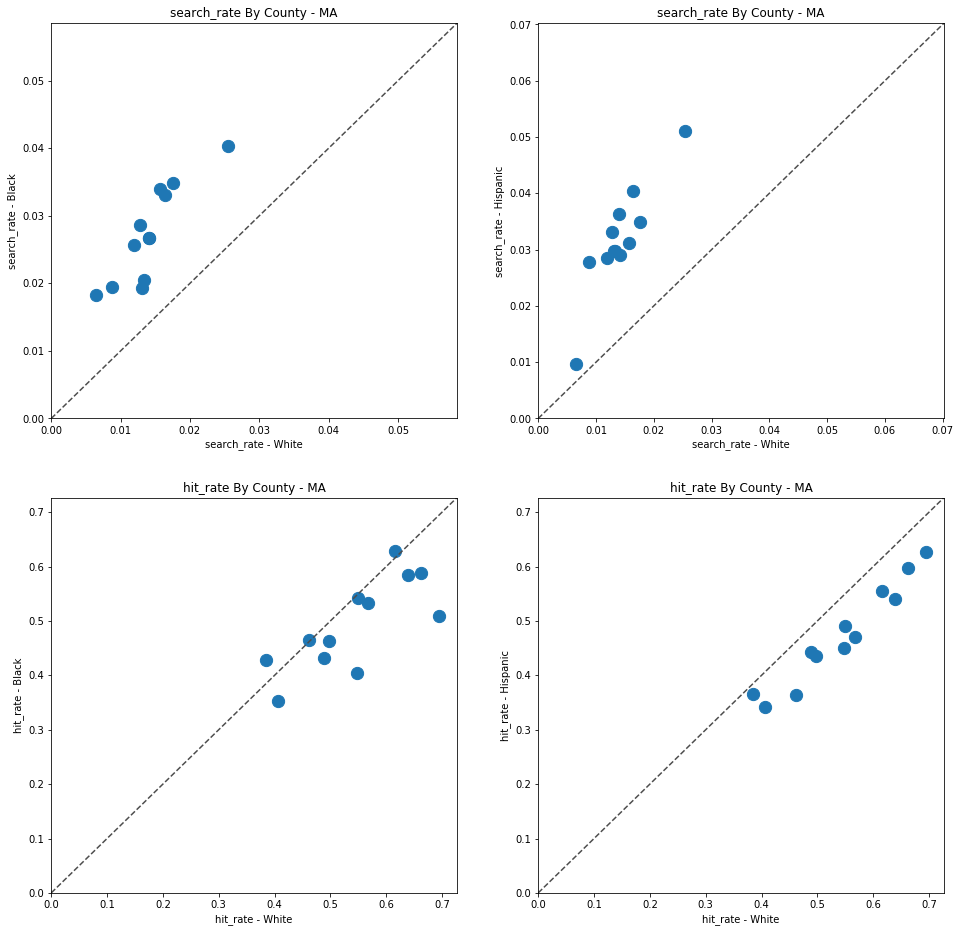

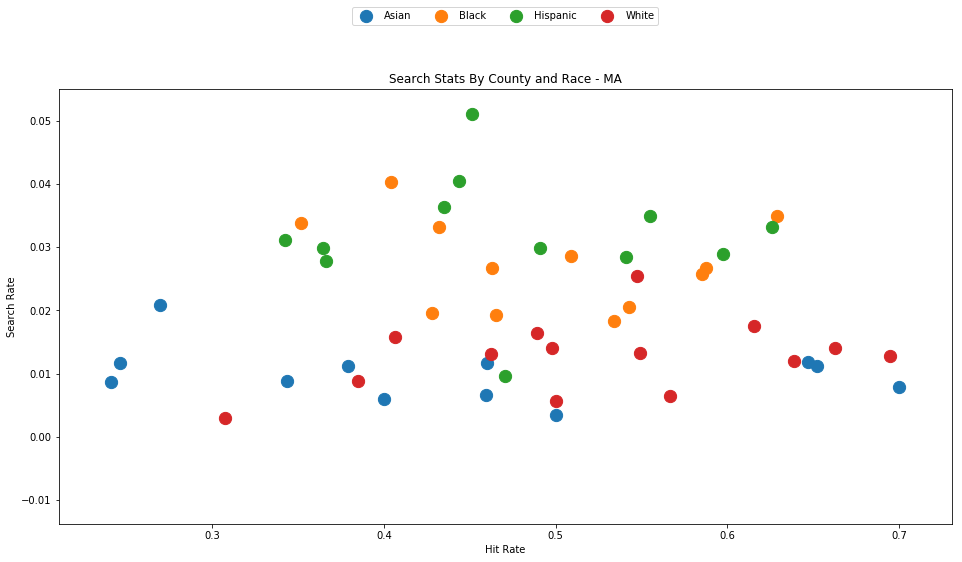

In [38]:
analyze_state_data('MA')

/Users/patrick/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,
Asian,0.470817,121.0,257.0,24577.0,0.010457
Black,0.477574,1299.0,2720.0,56050.0,0.048528
Hispanic,0.415741,449.0,1080.0,35210.0,0.030673
White,0.526300,5103.0,9696.0,778227.0,0.012459


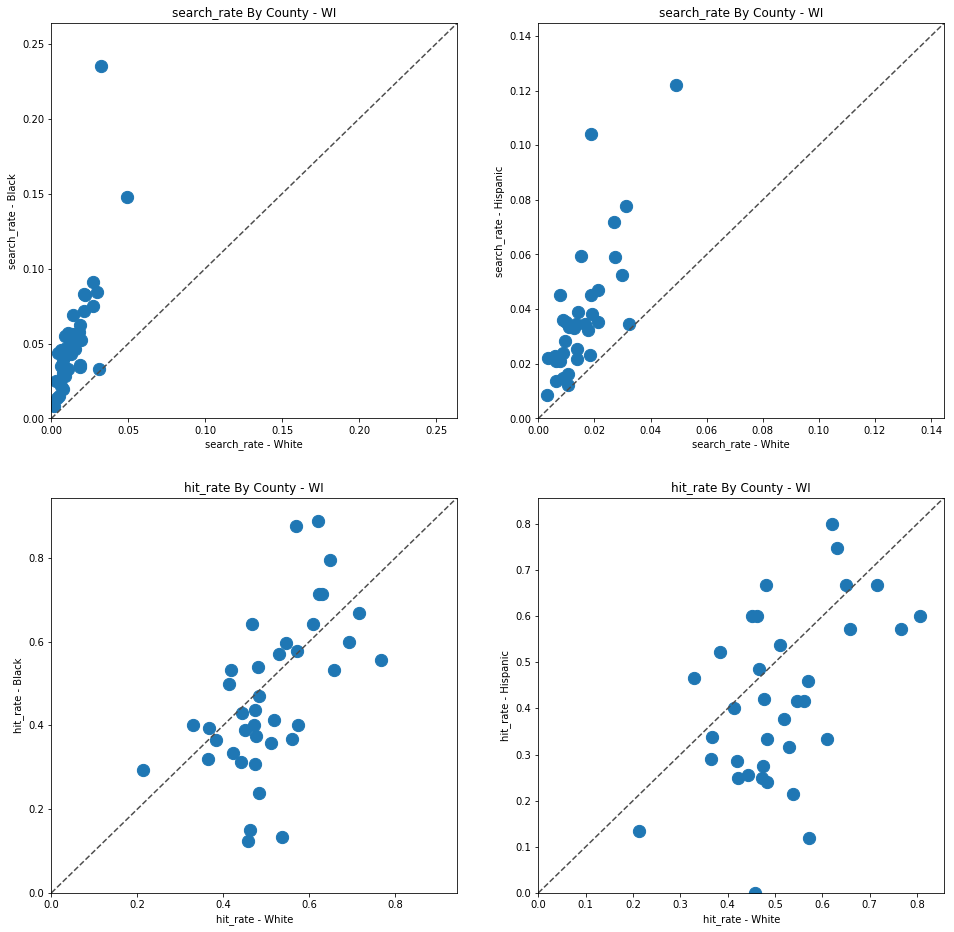

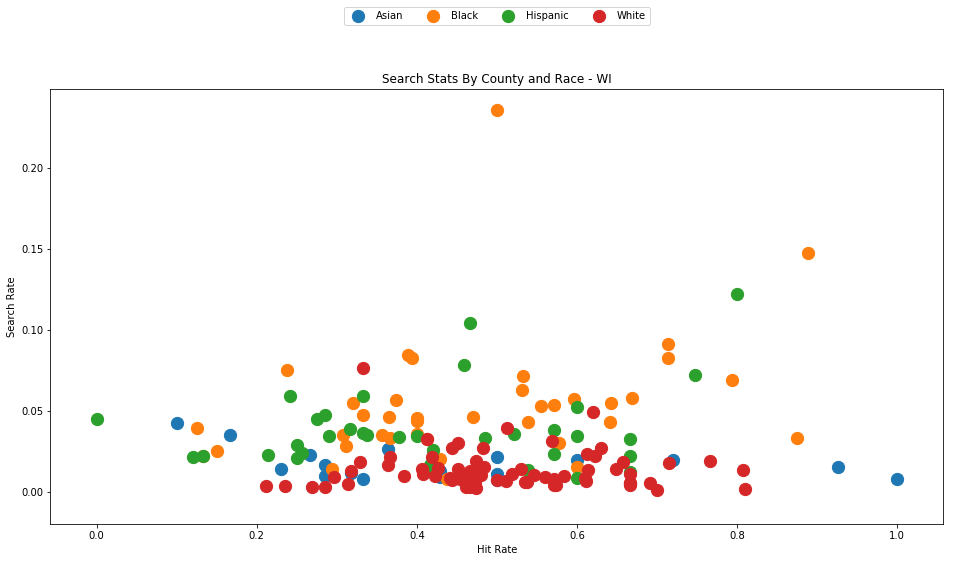

In [39]:
analyze_state_data('WI')

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>hit_rate</th>      <th>n_hits</th>      <th>n_searches</th>      <th>n_stops</th>      <th>search_rate</th>    </tr>    <tr>      <th>driver_race</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Asian</th>      <td>0.384615</td>      <td>10.0</td>      <td>26.0</td>      <td>5949.0</td>      <td>0.004370</td>    </tr>    <tr>      <th>Black</th>      <td>0.284072</td>      <td>346.0</td>      <td>1218.0</td>      <td>37460.0</td>      <td>0.032515</td>    </tr>    <tr>      <th>Hispanic</th>      <td>0.291925</td>      <td>282.0</td>      <td>966.0</td>      <td>31154.0</td>      <td>0.031007</td>    </tr>    <tr>      <th>White</th>      <td>0.379344</td>      <td>1179.0</td>      <td>3108.0</td>      <td>242314.0</td>      <td>0.012826</td>    </tr>  </tbody></table>'

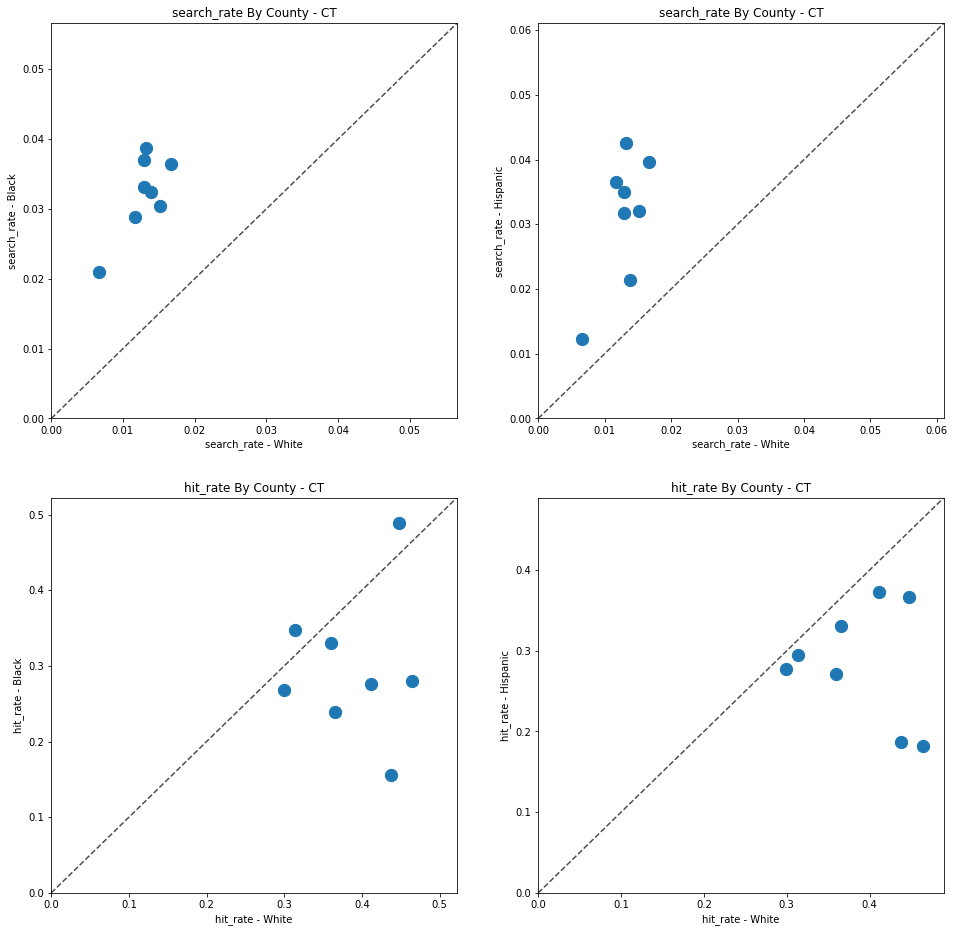

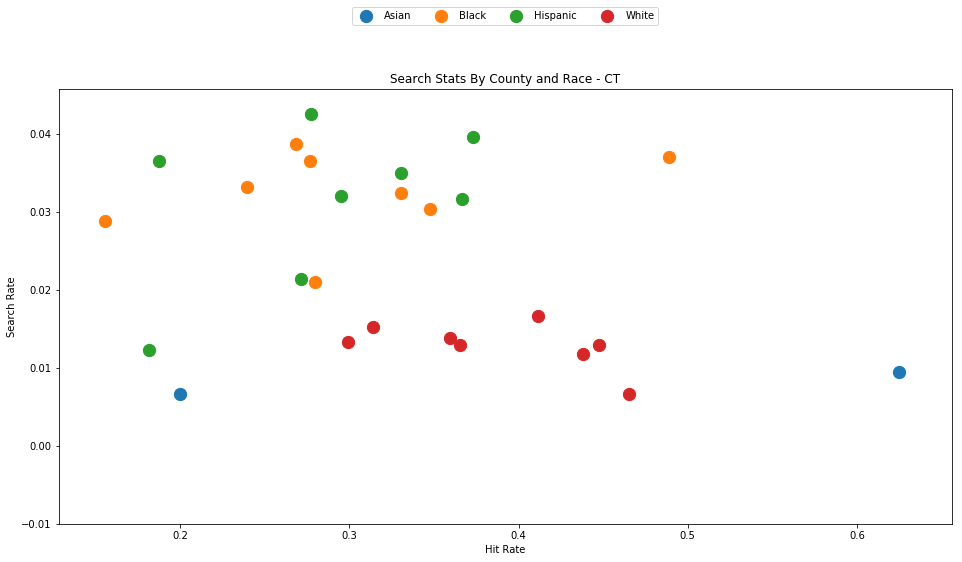

In [49]:
analyze_state_data('CT')

/Users/patrick/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>hit_rate</th>      <th>n_hits</th>      <th>n_searches</th>      <th>n_stops</th>      <th>search_rate</th>    </tr>    <tr>      <th>driver_race</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Asian</th>      <td>0.196664</td>      <td>224.0</td>      <td>1139.0</td>      <td>48177.0</td>      <td>0.023642</td>    </tr>    <tr>      <th>Black</th>      <td>0.255548</td>      <td>2188.0</td>      <td>8562.0</td>      <td>116795.0</td>      <td>0.073308</td>    </tr>    <tr>      <th>Hispanic</th>      <td>0.160930</td>      <td>5943.0</td>      <td>36929.0</td>      <td>501619.0</td>      <td>0.073620</td>    </tr>    <tr>      <th>White</th>      <td>0.242564</td>      <td>9288.0</td>      <td>38291.0</td>      <td>1212652.0</td>      <td>0.031576</td>    </tr>  </tbody></table>'

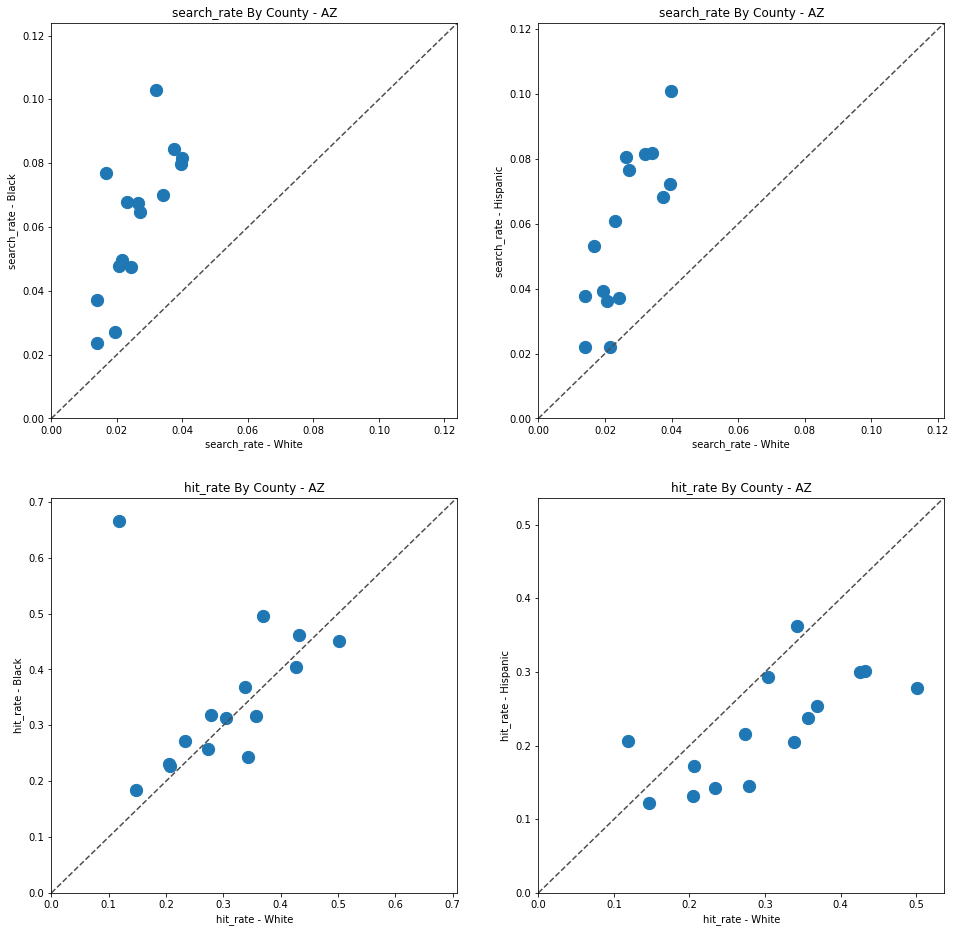

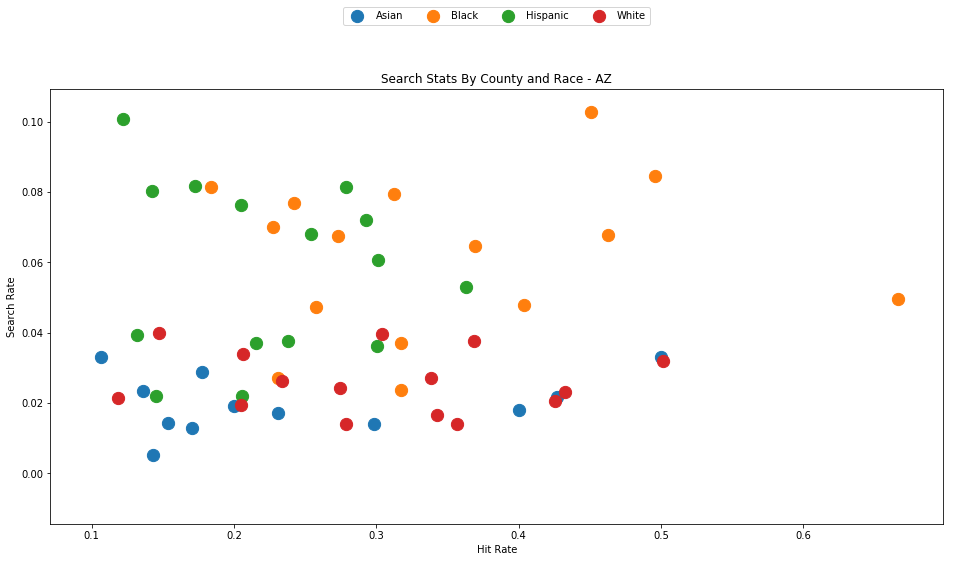

In [50]:
analyze_state_data('AZ')

/Users/patrick/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>hit_rate</th>      <th>n_hits</th>      <th>n_searches</th>      <th>n_stops</th>      <th>search_rate</th>    </tr>    <tr>      <th>driver_race</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Asian</th>      <td>0.537634</td>      <td>50.0</td>      <td>93.0</td>      <td>32471.0</td>      <td>0.002864</td>    </tr>    <tr>      <th>Black</th>      <td>0.481283</td>      <td>270.0</td>      <td>561.0</td>      <td>71965.0</td>      <td>0.007795</td>    </tr>    <tr>      <th>Hispanic</th>      <td>0.450454</td>      <td>1041.0</td>      <td>2311.0</td>      <td>308499.0</td>      <td>0.007491</td>    </tr>    <tr>      <th>White</th>      <td>0.651388</td>      <td>3638.0</td>      <td>5585.0</td>      <td>1767804.0</td>      <td>0.003159</td>    </tr>  </tbody></table>'

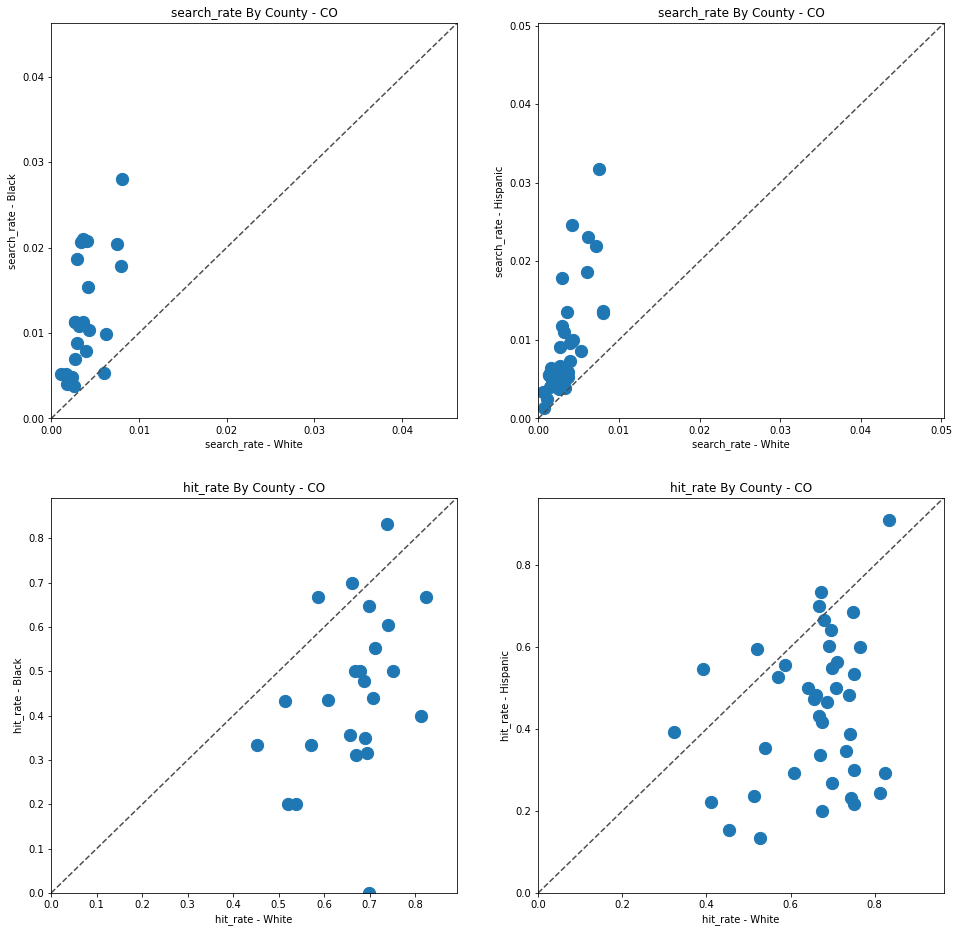

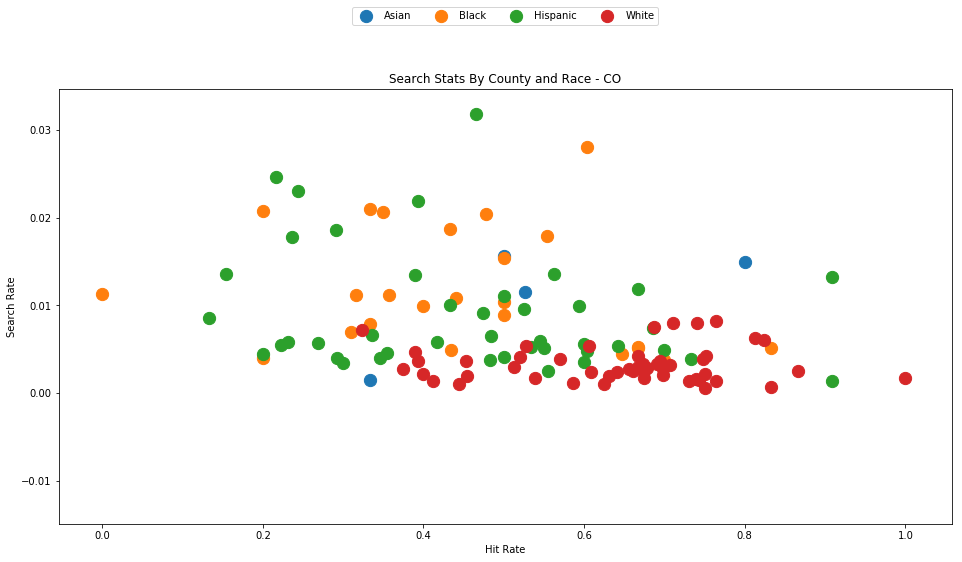

In [51]:
analyze_state_data('CO')

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>hit_rate</th>      <th>n_hits</th>      <th>n_searches</th>      <th>n_stops</th>      <th>search_rate</th>    </tr>    <tr>      <th>driver_race</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Asian</th>      <td>0.104377</td>      <td>31.0</td>      <td>297.0</td>      <td>46287.0</td>      <td>0.006416</td>    </tr>    <tr>      <th>Black</th>      <td>0.182489</td>      <td>1955.0</td>      <td>10713.0</td>      <td>1222533.0</td>      <td>0.008763</td>    </tr>    <tr>      <th>Hispanic</th>      <td>0.119330</td>      <td>776.0</td>      <td>6503.0</td>      <td>368878.0</td>      <td>0.017629</td>    </tr>    <tr>      <th>White</th>      <td>0.153850</td>      <td>3387.0</td>      <td>22015.0</td>      <td>3146302.0</td>      <td>0.006997</td>    </tr>  </tbody></table>'

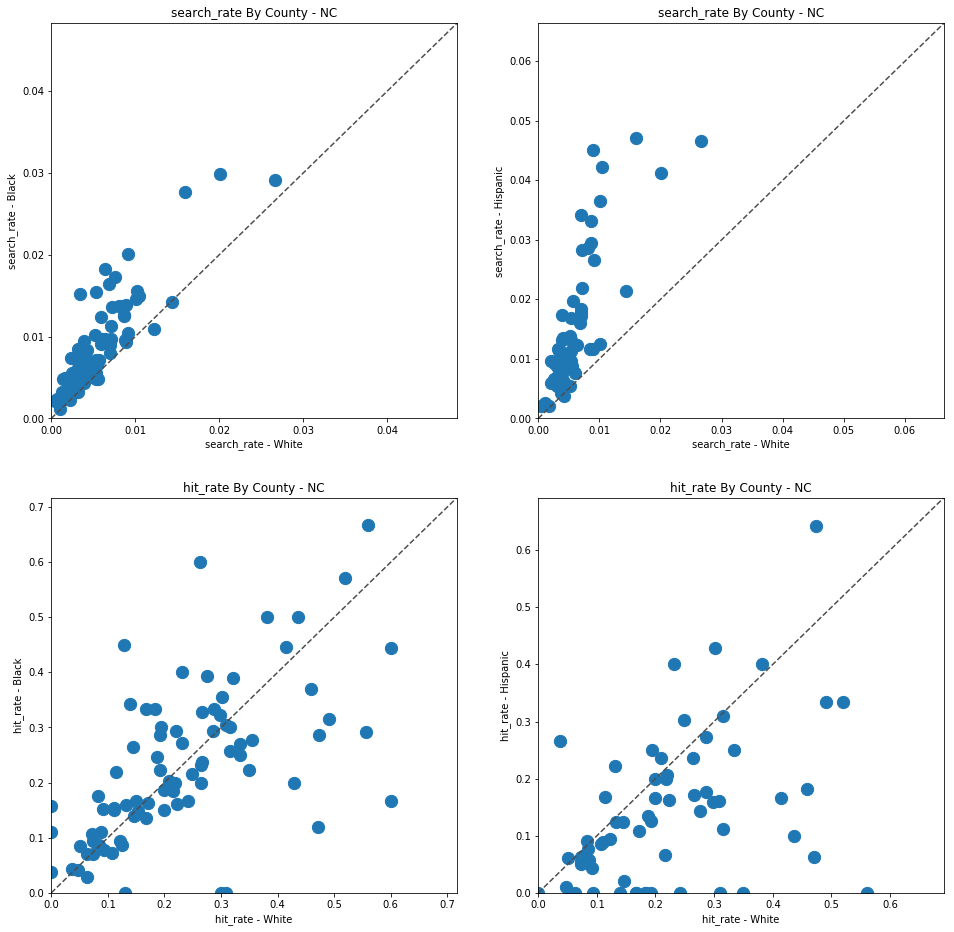

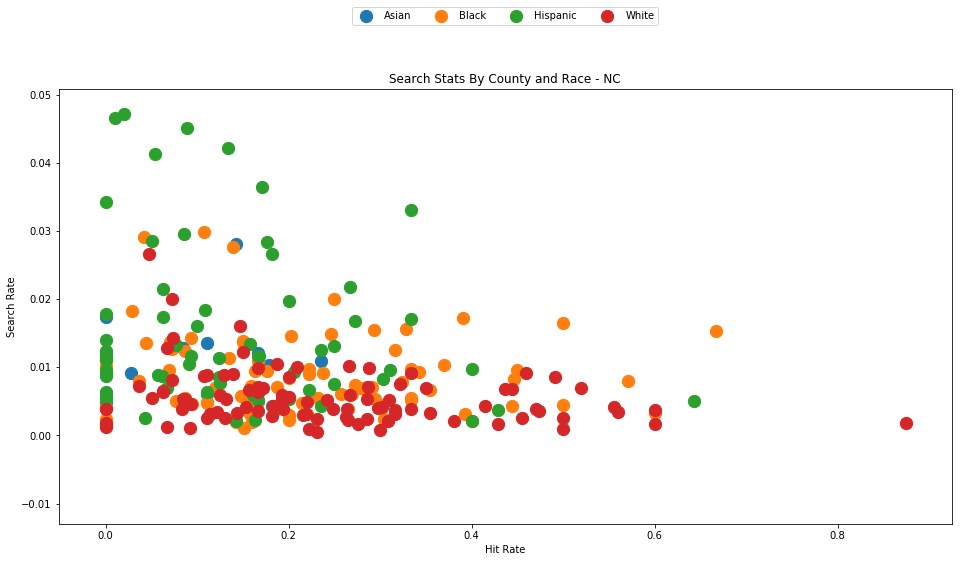

In [52]:
analyze_state_data('NC')

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>hit_rate</th>      <th>n_hits</th>      <th>n_searches</th>      <th>n_stops</th>      <th>search_rate</th>    </tr>    <tr>      <th>driver_race</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Asian</th>      <td>0.087143</td>      <td>608.0</td>      <td>6977.0</td>      <td>352063.0</td>      <td>0.019817</td>    </tr>    <tr>      <th>Black</th>      <td>0.130799</td>      <td>1717.0</td>      <td>13127.0</td>      <td>254577.0</td>      <td>0.051564</td>    </tr>    <tr>      <th>Hispanic</th>      <td>0.103366</td>      <td>2128.0</td>      <td>20587.0</td>      <td>502254.0</td>      <td>0.040989</td>    </tr>    <tr>      <th>White</th>      <td>0.156008</td>      <td>15768.0</td>      <td>101072.0</td>      <td>4279273.0</td>      <td>0.023619</td>    </tr>  </tbody></table>'

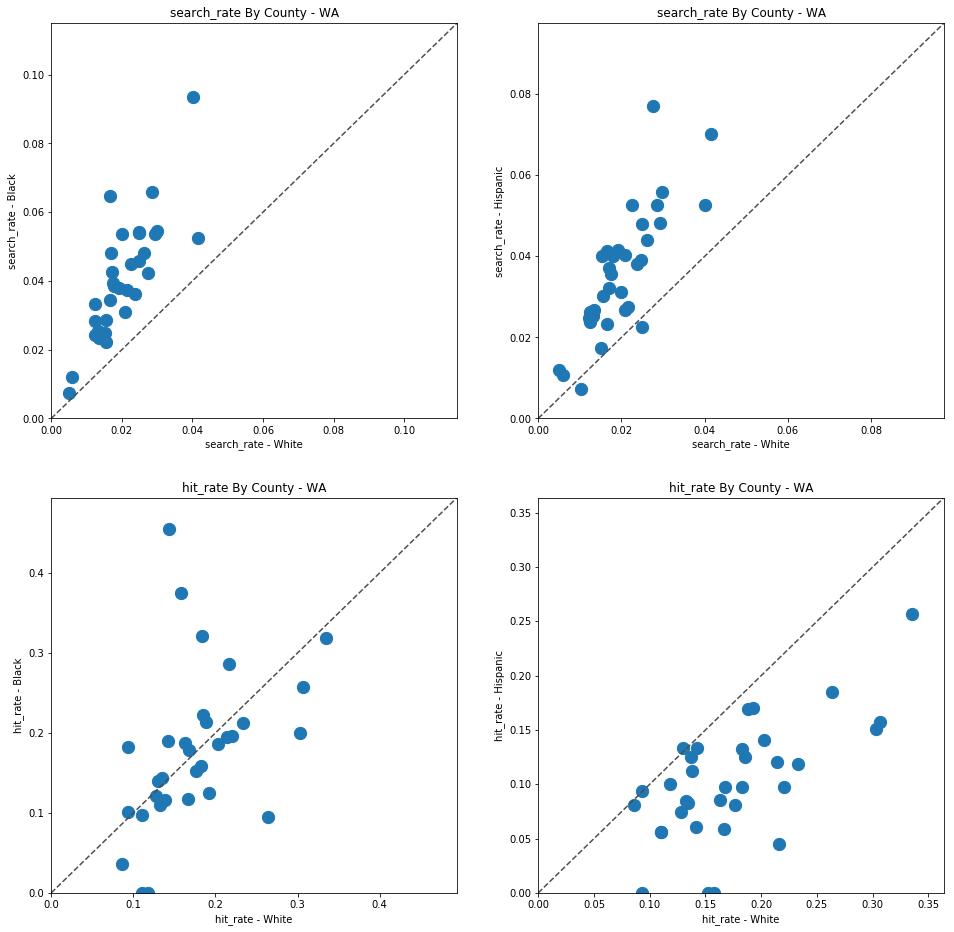

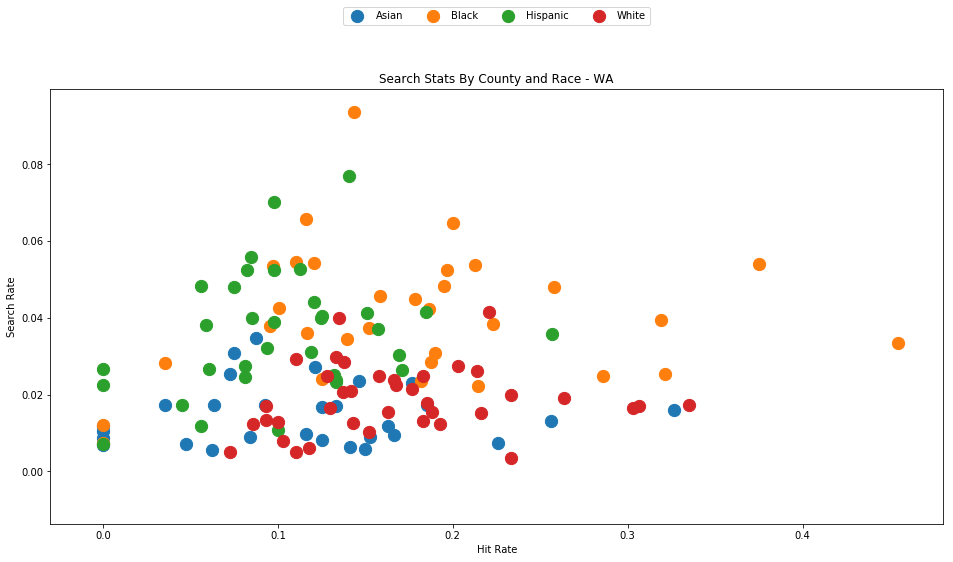

In [53]:
analyze_state_data('WA')

/Users/patrick/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:2808: DtypeWarning: Columns (16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>hit_rate</th>      <th>n_hits</th>      <th>n_searches</th>      <th>n_stops</th>      <th>search_rate</th>    </tr>    <tr>      <th>driver_race</th>      <th></th>      <th></th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Asian</th>      <td>0.289271</td>      <td>976.0</td>      <td>3374.0</td>      <td>349105.0</td>      <td>0.009665</td>    </tr>    <tr>      <th>Black</th>      <td>0.345983</td>      <td>27588.0</td>      <td>79738.0</td>      <td>2300427.0</td>      <td>0.034662</td>    </tr>    <tr>      <th>Hispanic</th>      <td>0.219449</td>      <td>37080.0</td>      <td>168969.0</td>      <td>6525365.0</td>      <td>0.025894</td>    </tr>    <tr>      <th>White</th>      <td>0.335098</td>      <td>83157.0</td>      <td>248157.0</td>      <td>13576726.0</td>      <td>0.018278</td>    </tr>  </tbody></table>'

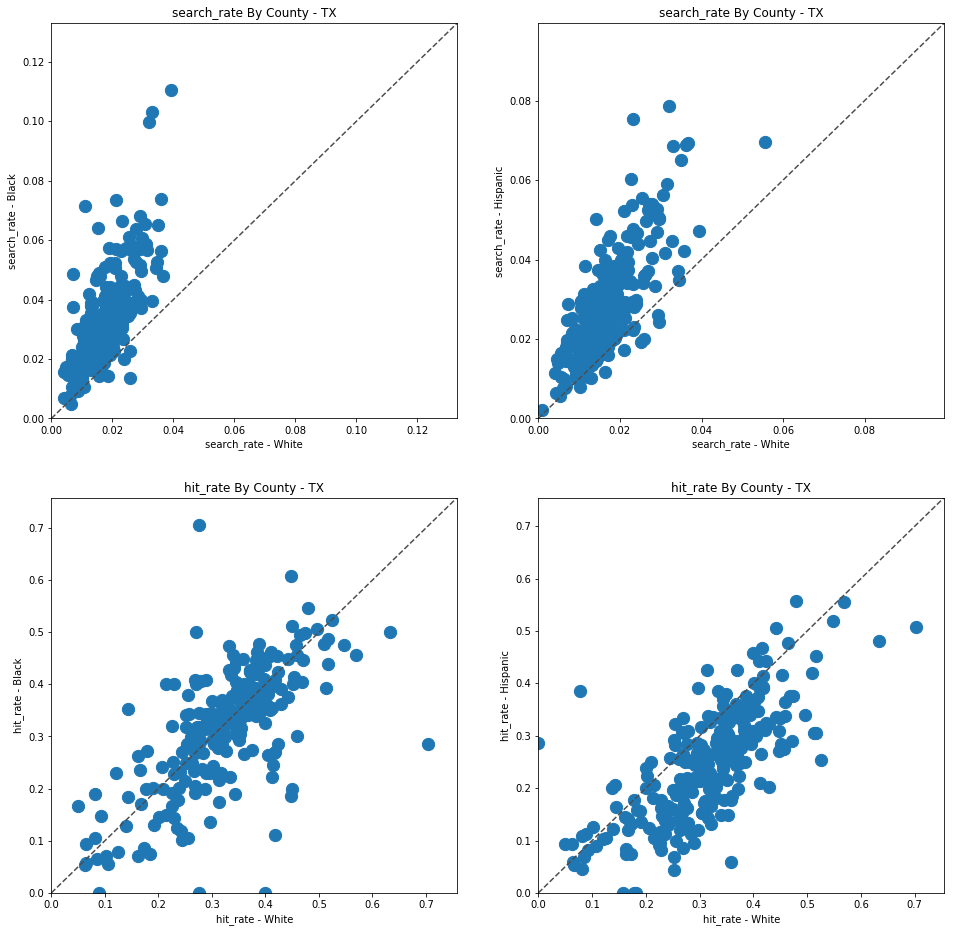

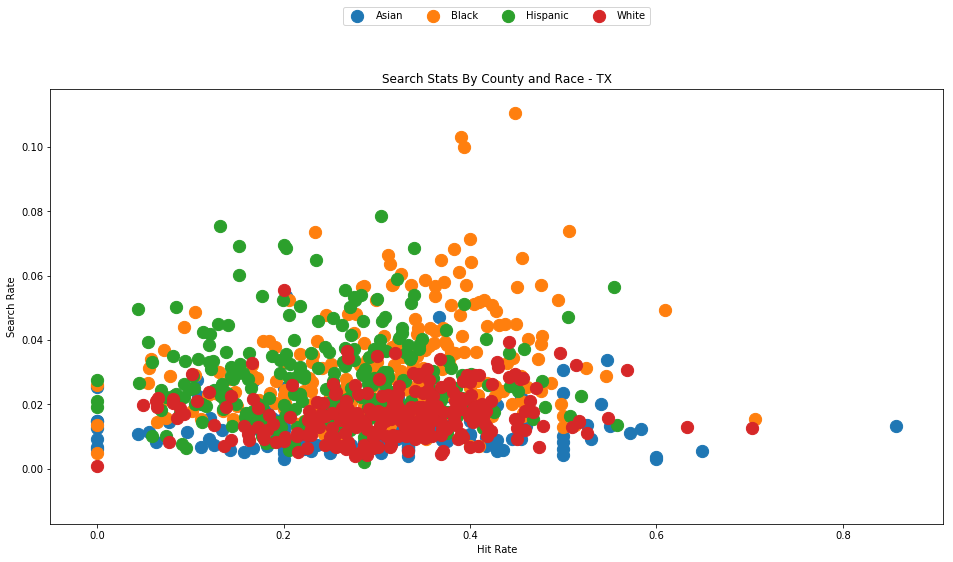

In [54]:
analyze_state_data('TX')